## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-30px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
LOAD_WEIGHTS_FILE = None

BATCH_SIZE=24

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=False)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-15 18:51:56,229 INFO Output dirs created


### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2017-04-15 18:51:56,238 INFO Load CNN model


### Prepare train, validate and test data flows

In [5]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

logger.info('train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file)

logger.info('train size ' + str(train_batch_generator.size) + ' ' + str(train_batch_generator.nr_batches))

image_randomize_generator = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=360,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=(1,1,1,1,1,1),
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False)

train_balance_generator.setup_flow(0, 0.01)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)

logger.info('validate data')
validate_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.99, end_ratio=1, batch_size=BATCH_SIZE)
logger.info('validate size ' + str(validate_batch_generator.size) + ' ' + str(validate_batch_generator.nr_batches))
validate_generator = validate_batch_generator

2017-04-15 18:51:56,427 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-30px-84-84.h5 as input
2017-04-15 18:51:56,430 INFO train data
2017-04-15 18:51:56,432 INFO train size 74304 1161.0
2017-04-15 18:51:56,433 INFO loading input data for class distribution analysis...
2017-04-15 18:51:56,435 INFO > [started] generator dump...


74304/74304

2017-04-15 18:52:23,061 INFO > [done]    generator dump (26626.168 ms)
2017-04-15 18:52:23,096 INFO raw sample class distribution
2017-04-15 18:52:23,097 INFO 0: 11610
2017-04-15 18:52:23,098 INFO 1: 0
2017-04-15 18:52:23,099 INFO 2: 40635
2017-04-15 18:52:23,101 INFO 3: 6966
2017-04-15 18:52:23,102 INFO 4: 15093
2017-04-15 18:52:23,103 INFO 5: 0
2017-04-15 18:52:23,105 INFO overall output samples per class: 6966
2017-04-15 18:52:23,106 INFO augmentation/undersampling ratio per class
2017-04-15 18:52:23,107 INFO SETUP FLOW 0 1
2017-04-15 18:52:23,108 INFO output distribution
2017-04-15 18:52:23,110 INFO 0: 0.6 (6966.0)
2017-04-15 18:52:23,111 INFO 1: 0.0 (0.0)
2017-04-15 18:52:23,112 INFO 2: 0.171428571429 (6966.0)
2017-04-15 18:52:23,113 INFO 3: 1.0 (6966.0)
2017-04-15 18:52:23,115 INFO 4: 0.461538461538 (6966.0)
2017-04-15 18:52:23,116 INFO 5: 0.0 (0.0)
2017-04-15 18:52:23,117 INFO estimated size: 27840
2017-04-15 18:52:23,119 INFO calculating source range according to start/end rang

In [12]:
logger.info('show input dataset samples')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
with h5py.File(input_dataset_path, 'r') as h5file:
    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=0.001, batch_size=64)
    logger.info('input_generator.size=' + str(input_generator.size))
    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
    logger.info('dump len ' + str(len(X)) + ' ' + str(len(Y)) + ' ' + str(np.shape(X)))
    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)

logger.info('dump balancer generator data')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_balance_generator.flow(), train_balance_generator.size)
print(np.shape(X_train))
print(np.shape(Y_train))
print(utils.class_distribution(Y_train).astype('uint'))

print('show images from generator')
c = 0
for xs,ys in train_balance_generator.flow():
    if(c>=1):
        break
    c += 1
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
#    for i,x in enumerate(xs):
#        if(c>=3):
#            break
#       print('Y: ' + str(ys[i]))
#        print('X: ' + str(np.shape(x)))
#        utils.show_image(x, is_bgr=True)


SyntaxError: invalid syntax (<ipython-input-12-77d67c0bafed>, line 8)

## Train model

In [7]:
if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(WEIGHTS_FILE)

logger.info('Starting CNN training...')

history = model.fit_generator(train_generator,
              steps_per_epoch = train_balance_generator.nr_batches,
              nb_epoch = 1, 
              callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
              validation_data = validate_generator.flow(), 
              validation_steps = validate_generator.nr_batches,
              verbose = 1)

if(SAVE_WEIGHTS_FILE!=None):
    logger.info('Saving last weights...')
    model.save_weights(SAVE_WEIGHTS_FILE)

2017-04-15 18:52:32,145 INFO Starting CNN training...
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, epochs=1, validation_steps=30.0, validation_data=<generator..., steps_per_epoch=4.0, callbacks=None)`
2017-04-15 18:52:32,844 INFO starting new flow...
2017-04-15 18:52:32,846 INFO source range is 0-723


Epoch 1/1


/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4/4 [==============================] - 19s - loss: 1.5912 - acc: 0.1953 - val_loss: 1.4946 - val_acc: 0.4028

2017-04-15 18:52:51,954 INFO Saving last weights...


### Epoch accuracy/loss

2017-04-15 18:52:52,182 INFO Training info


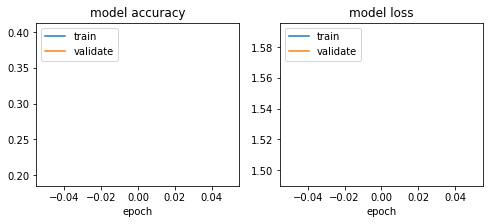

In [8]:
logger.info('Training info')
cnn.show_training_info_keras(history)

### Confusion matrix

2017-04-15 18:52:52,552 INFO Evaluating model performance (740 samples)...
2017-04-15 18:53:01,480 INFO Accuracy: 0.494594595722 - Loss: 1.45456390929
2017-04-15 18:53:01,481 INFO Predicting Y for detailed analysis...
2017-04-15 18:53:10,628 INFO > [started] generator dump...


740/740

2017-04-15 18:53:11,021 INFO > [done]    generator dump (393.188 ms)
2017-04-15 18:53:11,023 INFO Nr test samples: 740|740
2017-04-15 18:53:11,026 INFO Kappa score (was this luck?): 0.00213447171825
2017-04-15 18:53:11,028 INFO Confusion matrix:
2017-04-15 18:53:11,029 INFO [[  2  72   0]
 [  6 364   0]
 [  4 292   0]]


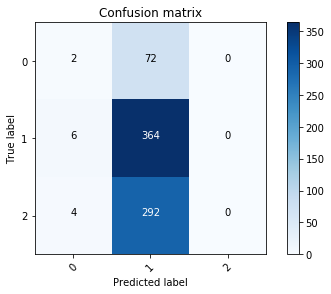

In [9]:
from sklearn import metrics
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
with h5py.File(input_dataset_path, 'r') as h5file:
    test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.7, end_ratio=0.71, batch_size=10)
    cnn.evaluate_dataset_keras(test_batch_generator.flow(), test_batch_generator.nr_batches, test_batch_generator.size, model)